In [5]:
import pandas as pd
import sqlite3
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.stats import ranksums
!pip install statsmodels
!pip install dash==2.6.0
#!pip install mysql
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import datasets
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import time
import datetime
%matplotlib inline

con = sqlite3.connect('Downloads/MIRAMAR_trial_FULL.db')
cur = con.cursor()


[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Creating one table that includes all of the different values which are initially stored in separate tables

In [6]:
# joined_table
sql = '''
SELECT ph.level, lt.timestamp, lt.lat, lt.lon, lt.boat_id, temperature.degree, dissolved_solids.ppm
FROM location_time AS lt 
INNER JOIN ph
ON ph.locationtime_id = lt.id
INNER JOIN temperature
ON temperature.locationtime_id = lt.id
INNER JOIN dissolved_solids
ON dissolved_solids.locationtime_id = lt.id
'''
df_wtr = pd.read_sql(sql, con)
df_wtr.head()

df_wtr['ppm'] = pd.to_numeric(df_wtr['ppm'], errors = 'coerce')
df_wtr['degree'] = pd.to_numeric(df_wtr['degree'], errors = 'coerce')
df_wtr.dropna(inplace = True)

import pytz
from datetime import timezone
from pytz import timezone, utc
from datetime import datetime

df_wtr.timestamp = pd.to_datetime(df_wtr.timestamp,format= '%Y-%m-%d %H:%M:%S')
df_wtr['timestamp'] = df_wtr['timestamp'].dt.tz_localize('GMT').dt.tz_convert('America/Los_Angeles')
df_wtr['level'] = df_wtr['level'] - 9
df_wtr = df_wtr[df_wtr['level'] >= 4]  
df_wtr.round(2)
df_wtr.head()


,level,timestamp,lat,lon,boat_id,degree,ppm
292,6.61,2022-07-29 13:34:22-07:00,32.914089,-117.100055,1.0,25.50,1068.22
293,6.56,2022-07-29 13:34:24-07:00,32.914091,-117.100052,1.0,25.94,1062.56
294,6.37,2022-07-29 13:34:26-07:00,32.914090,-117.100050,1.0,26.38,1053.53
295,5.81,2022-07-29 13:34:28-07:00,32.914093,-117.100048,1.0,26.69,1057.95
296,5.89,2022-07-29 13:34:30-07:00,32.914093,-117.100047,1.0,26.94,1044.65


### Exploratory Data Analysis(EDA)
Charts, graphs, relationships between features

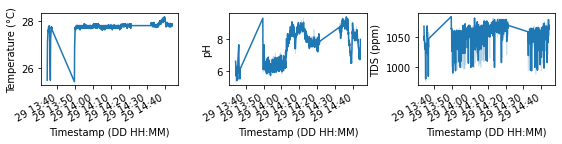

In [7]:
# Establish a 3 column facet for temp, pH, and TDS
fig, axs = plt.subplots(ncols=3, figsize=(8,1.5))
fig.tight_layout(h_pad=10)

g1 = sns.lineplot(
    data= df_wtr, 
    x="timestamp", 
    y="degree",
    ax=axs[0]
)
g1.figure.autofmt_xdate()
g1.set(
    xlabel='Timestamp (DD HH:MM)',
    ylabel='Temperature (°C)'
)

g2 = sns.lineplot(
    data= df_wtr, 
    x="timestamp", 
    y="level",
    ax=axs[1]
)
g2.set(
    xlabel='Timestamp (DD HH:MM)',
    ylabel='pH'
)
g2.figure.autofmt_xdate()

g3 = sns.lineplot(
    data= df_wtr, 
    x="timestamp", 
    y="ppm",
    ax=axs[2]
)
g3.set(
    xlabel='Timestamp (DD HH:MM)',
    ylabel='TDS (ppm)'
)
g3.figure.autofmt_xdate()

In [8]:
df_wtr['transect category'] = "Transect 1"
df_wtr.loc[df_wtr['timestamp'] > "2022-07-29 13:45:00", "transect category"] = "Transect 2"
df_wtr.loc[df_wtr['timestamp'] > "2022-07-29 14:35:00", "transect category"] = "Transect 3"
df_wtr['transect'] = "transect category"
df_wtr.head()

,level,timestamp,lat,lon,boat_id,degree,ppm,transect category,transect
292,6.61,2022-07-29 13:34:22-07:00,32.914089,-117.100055,1.0,25.50,1068.22,Transect 1,transect category
293,6.56,2022-07-29 13:34:24-07:00,32.914091,-117.100052,1.0,25.94,1062.56,Transect 1,transect category
294,6.37,2022-07-29 13:34:26-07:00,32.914090,-117.100050,1.0,26.38,1053.53,Transect 1,transect category
295,5.81,2022-07-29 13:34:28-07:00,32.914093,-117.100048,1.0,26.69,1057.95,Transect 1,transect category
296,5.89,2022-07-29 13:34:30-07:00,32.914093,-117.100047,1.0,26.94,1044.65,Transect 1,transect category


### Pairplot 
to see if one of the features seems to be able to predict another

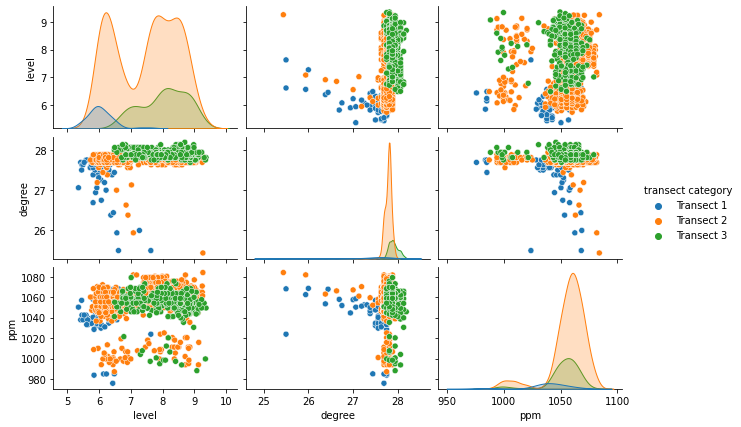

In [9]:
df_wtr_features = df_wtr[['level', 'degree', 'ppm', 'transect category']]
sns.pairplot(
    data = df_wtr_features,
  #  palette=sns.color_palette(palette = colors, n_colors=2),
    height = 2, 
    aspect = 1.5,
    hue = "transect category"
)

level vs ppm appears to have a positive linear correlation. No other relationships are clear at this point. 

### Correlation Plot

In [10]:
corr = df_wtr[['level', 'degree', 'ppm']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\clair\AppData\Local\Temp\ipykernel_20752\3221601038.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,level,degree,ppm
level,1.00,0.20,0.19
degree,0.20,1.00,-0.03
ppm,0.19,-0.03,1.00


### Density map 
to display severity of features at correct lon and lat on map

In [31]:
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import Dash, dash_table
from dash import dcc
from dash import html
from dash.dependencies import Input, Output, State

df_wtr['level'].round(decimals = 2)

fig = px.scatter_mapbox(df_wtr, lat="lat", lon="lon", hover_data=["boat_id", "level", "degree", "ppm", "timestamp", "transect category"], height=600, color="transect category")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

### Linear Regression

In [12]:
df_wtr2 = df_wtr[df_wtr.boat_id == 1] 

model2 = ols('level ~ ppm', data=df_wtr2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  level   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     47.79
Date:                Wed, 03 Aug 2022   Prob (F-statistic):           7.61e-12
Time:                        11:41:59   Log-Likelihood:                -1726.5
No. Observations:                1224   AIC:                             3457.
Df Residuals:                    1222   BIC:                             3467.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7465      1.773     -2.678      0.008      -8.224      -1.269
ppm            0.0116      0.002      6.913      0.000       0.008       0.015
==============================================================================
Omnibus:                      581.153   Durbin-Watson:                   0.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.878
Skew:                          -0.102   Prob(JB):                     1.82e-15
Kurtosis:                       1.865   Cond. No.                     6.59e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='ppm', ylabel='level'>

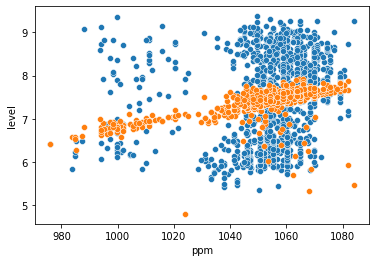

In [13]:
predx1 = df_wtr['ppm']
predx2 = df_wtr['degree']
predy = predx1 * 0.0119 + predx2 * 0.9974 - 32.8145
# predy = -32 + (coef1 * ppm + coef2 * degree) 

sns.scatterplot(data = df_wtr, x = 'ppm', y = 'level', palette = ['blue'])
sns.scatterplot(x = predx1, y = predy)

## Evaluating Goodness of Fit -- Checking Model Assumptions

* Independence Assumption
* Linearity / Mean Zero Assumption
* Constant Variance Assumption
* Normality Assumption

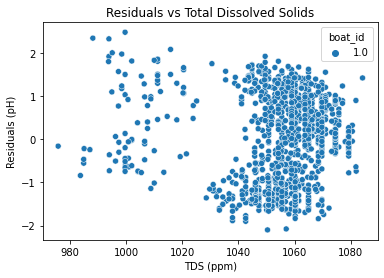

In [15]:
g = sns.scatterplot(
    data=df_wtr,
    x='ppm',
    y=model2.resid,
    hue='boat_id',
).set(
    title='Residuals vs Total Dissolved Solids',
    xlabel='TDS (ppm)',
    ylabel='Residuals (pH)'
)

#### Checking Independence Assumption 

**Are the data independently pulled from the population?  You can't really check for this after the fact.  It should be built into the experiment from the beginning.**

There may be some clustering around 1000 ppm and 1060 ppm, so the independence assumption may not hold.

#### Constant Variance Assumption

**Does the variance of the residuals appear to be the same throughout the residuals graph?**

The constant variance assumption appears to hold because there appears to be the same variance at low and high ppm values.

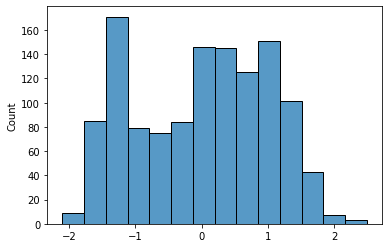

In [16]:
g = sns.histplot(
    x = model2.resid
)

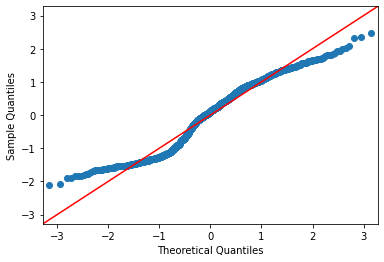

In [17]:
g = sm.qqplot(
    model2.resid,
    line='45'
)

In [18]:
from scipy.stats import normaltest
z_score_stat, p_value = normaltest(model2.resid)
print("Z-score statistic",z_score_stat)
print("p-value",p_value)

Z-score statistic 581.1532781197341
p-value 6.370434963499156e-127


#### Normality Assumption

**Do the residuals appear to come from a normal distribution?**

Both the Q-Q Plot and the normality test suggest that the residuals are not pulled from a normal distribution, and the normality assumption may not hold.

### Training and Testing

In [19]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

#features = ['ppm','degree']
#X = df_wtr.loc[:, features]
X = df_wtr.loc[:, ['ppm']]
y = df_wtr.loc[:, ['level']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .80)

In [21]:
reg.fit(X_train, y_train)

NameError: name 'reg' is not defined

In [22]:
df_wtr3 = X_test

model3 = ols('y_test ~ X_test', data=df_wtr3).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_test   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     9.207
Date:                Wed, 03 Aug 2022   Prob (F-statistic):            0.00267
Time:                        11:45:57   Log-Likelihood:                -338.96
No. Observations:                 245   AIC:                             681.9
Df Residuals:                     243   BIC:                             688.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4042      3.616     -0.942      0.347     -10.526       3.718
X_test         0.0104      0.003      3.034      0.003       0.004       0.017
==============================================================================
Omnibus:                       53.029   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.457
Skew:                          -0.253   Prob(JB):                      0.00120
Kurtosis:                       1.970   Cond. No.                     6.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:xlabel='ppm', ylabel='level'>

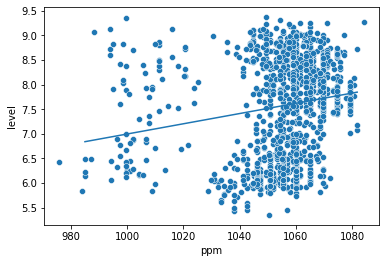

In [23]:
predictions = X_test
predictions['y_hat'] = predictions['ppm'] * 0.0104 - 3.4042
sns.scatterplot(data = df_wtr, x = 'ppm', y = 'level', palette = ['blue'])
sns.lineplot(data=predictions, x='ppm', y='y_hat')

The R-Squared value for the entire dataset is 0.037, which means that this model may not be ideal. There were two humps in the residuals, the the smaller first hump may be a result of rounding issues with the sensors. We can clean the data to ignore the values in this smaller hump to see if that model would be better. 

In [26]:
df_wtr2 = df_wtr2[df_wtr2.degree > 27.5]
df_wtr2 = df_wtr2[df_wtr2.ppm > 1025]

In [27]:
model = ols('level ~ ppm + degree', data=df_wtr2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  level   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     101.2
Date:                Wed, 03 Aug 2022   Prob (F-statistic):           4.36e-41
Time:                        11:47:14   Log-Likelihood:                -1481.3
No. Observations:                1110   AIC:                             2969.
Df Residuals:                    1107   BIC:                             2984.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -100.0278      8.941    -11.187      0.000    -117.572     -82.484
ppm            0.0322      0.003     11.324      0.000       0.027       0.038
degree         2.6433      0.301      8.774      0.000       2.052       3.234
==============================================================================
Omnibus:                      165.959   Durbin-Watson:                   0.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.558
Skew:                           0.068   Prob(JB):                     1.56e-09
Kurtosis:                       2.073   Cond. No.                     3.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\clair\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



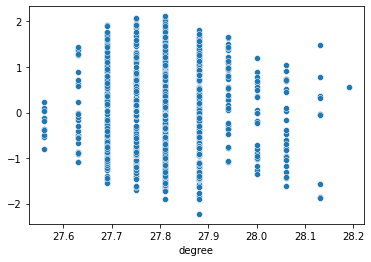

In [28]:
g = sns.scatterplot(df_wtr.degree, model.resid)

C:\Users\clair\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



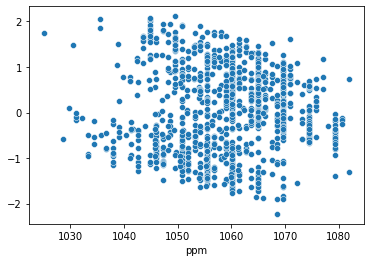

In [29]:
g = sns.scatterplot(df_wtr.ppm, model.resid)

<AxesSubplot:ylabel='Count'>

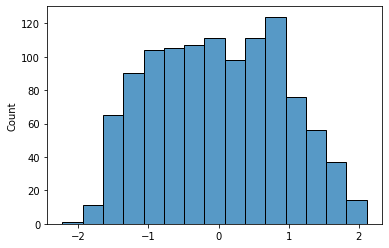

In [30]:
# 
sns.histplot(
    x=model.resid
)

The R-squared value is now 0.155, which is an improvement from before. This may mean that using the dataset that has been cleaned more may result in a better model. 

In [32]:
corr = df_wtr2[['level', 'degree', 'ppm']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\clair\AppData\Local\Temp\ipykernel_20752\3952984353.py:2: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,level,degree,ppm
level,1.00,0.24,0.31
degree,0.24,1.00,-0.01
ppm,0.31,-0.01,1.00
